### Overview About the Problem

How might we predict the amount of crop yield in a given area given the information on the climate and soil nutrients used to empower farmers with actionable insights for efficient resource management and agricultural practices?

As we approach a global population of 9 billion by 2050, ensuring sustainable ways to meet basic human needs becomes increasingly urgent. Addressing food security is a paramount concern in this scenario, and India plays a crucial role as the largest exporter of staple crops, particularly rice. With nearly 40 percent of total rice exports and a projection to reach 54 million tonnes in the 2022-2023 crop year, India's rice production significantly impacts global food security. 

Focusing our model on Indian rice production is key because the world heavily relies on rice as a staple, making it a center in the global food supply. By understanding and optimizing rice production in India, we aim to contribute to the broader challenge of ensuring a sustainable and secure global food future

### User Persona

1) Eddie is running a large farm on the coast of a city growing crops like wheat, rice, and tomatoes. Often, Eddie finds himself putting too much or too little fertiliser in the soil of his crops, resulting in a lot of his crops not growing healthily.
Pain Points:
Faces challenges in optimising the amount of fertiliser for various crops, especially finding difficulty in finding the right amount of fertiliser to use. 
Desire precise data on temperature, precipitation, and soil quality for tailored cultivation in controlled environments. Aims to maximise crop production and resource efficiency in a limited urban space.

2) James owns a large-scale agricultural operation in a temperate zone with varying precipitation patters that grows a variety of crops.
Pain Points:
Challenges in determining the optimal temperature range for different crops to maximise yield.
Difficulty in managing irrigation and water resources
Lack of information on the impact of precipitation on crop growth
Difficulty in understanding the impact of temperature on crop growth and yield.
Lack of tools or models that integrate temperature data with other factors like fertilizer usage and for comprehensive analysis.
Desire to mitigate the risks associated with extreme temperature events and their impact on crop yield as well as precipitation data to plan for irrigation in order to maximise crop production.


### Dataset required
- N_value: https://www.fao.org/faostat/en/#compare
- P_value: https://www.fao.org/faostat/en/#compare
- K_value: https://www.fao.org/faostat/en/#compare
- Rice_yield_india: https://www.fao.org/faostat/en/#compare
- Rainfall: https://www.kaggle.com/datasets/rajanand/rainfall-in-india?select=rainfall+in+india+1901-2015.csv
- Temperature: https://www.kaggle.com/datasets/venky73/temperatures-of-india

### Libraies required

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Functions required

In [2]:
def normalize_z(dfin, columns_means=None, columns_stds=None):
    dfout = dfin.copy()
    
    if columns_means is None:
        columns_means = dfout.mean(axis=0) 
        
    if columns_stds is None:
        columns_stds = dfout.std(axis=0)
        
    dfout = (dfout - columns_means) / columns_stds
    
    return dfout, columns_means, columns_stds

def get_features_targets(df, feature_names, target_names):
    df_feature=df[feature_names]
    df_target=df[target_names]
    return df_feature, df_target

def calc_linreg(X, beta):
    return np.matmul(X,beta)

def compute_cost_linreg(X, y, beta):
    J = 0
    m=X.shape[0]
    y_hat=calc_linreg(X,beta)
    err=y_hat-y
    sq_sum=np.matmul(err.T,err)
    J=sq_sum/(m*2)
    J=J[0][0]
    return J

def prepare_feature(df_feature):
    rows,col=df_feature.shape
    if type(df_feature)==pd.DataFrame:
        np_feature=df_feature.to_numpy()
    else:
        np_feature=df_feature
    feature=np_feature.reshape(-1,col)
    x0=np.ones((rows,1))
    X=np.concatenate((x0,feature),axis=1)
    return X
def prepare_target(df_target):
    rows,col=df_target.shape
    if type(df_target)==pd.DataFrame:
        np_target=df_target.to_numpy()
    else:
        np_target=df_target
    target=np_target.reshape(-1,col)
    return target
def r2_score(y, ypred):
    err=y-ypred
    ss_res=np.matmul(err.T,err)
    y_bar=np.mean(y)
    y_s=y-y_bar
    ss_tot=np.matmul(y_s.T,y_s)
    return 1- ss_res/ss_tot

def mean_squared_error(target, pred):
    target,pred=np.array(target),np.array(pred)
    n=target.shape[0]
    err=target-pred
    sq=np.matmul(err.T, err)
    return sq/n

def gradient_descent_linreg(X, y, beta, alpha, num_iters):
    m=X.shape[0]
    J_storage=[]
    for i in range(num_iters):
        j=compute_cost_linreg(X,y,beta)
        J_storage.append(j)
        y_hat=calc_linreg(X,beta)
        err=y_hat-y
        deriv=np.matmul(X.T,err)/m
        beta=beta-alpha*deriv
    return beta, J_storage


def predict_linreg(df_feature, beta, means=None, stds=None):
    df_feature,means,stds=normalize_z(df_feature,means,stds)
    feature=prepare_feature(df_feature)
    return calc_linreg(feature,beta)

def split_data(df_feature, df_target, random_state=None, test_size=0.6):
    indexes=df_feature.index
    if random_state is not None:
        np.random.seed(random_state)
    k=int(test_size*len(indexes))
    test_indexes=np.random.choice(indexes, k, replace=False)
    train_indexes=list(set(indexes)-set(test_indexes))
    train_indexes, test_indexes=sorted(train_indexes), sorted(test_indexes)
    df_feature_train=df_feature.loc[train_indexes, :]
    df_feature_test=df_feature.loc[test_indexes, :]
    df_target_train =df_target.loc[train_indexes, :]
    df_target_test = df_target.loc[test_indexes, :]
                                    
    return df_feature_train, df_feature_test, df_target_train, df_target_test

### Load datasets

In [3]:
#dataset defining
df_rainfall = pd.read_csv('rainfall_india.csv', index_col=0)
df_nitrogen = pd.read_csv('nvalue_per_area.csv', index_col=0)
df_temp = pd.read_csv('temp_india.csv', index_col=0)
df_yield = pd.read_csv('rice_yield_india.csv', index_col=0)
df_potash = pd.read_csv('kvalue_per_area.csv', index_col=0)
df_phosphate = pd.read_csv('pvalue_per_area.csv', index_col=0)

# creating a new dataset and cleaning
df_rainfall = df_rainfall.rename(columns={'ANNUAL': 'Rainfall'})
df_nitrogen = df_nitrogen.rename(columns={'Value': 'Nutrients_N'})
df_temp = df_temp.rename(columns={'ANNUAL': 'Temp'})
df_potash = df_potash.rename(columns={'Value': 'Nutrients_P'})
df_yield = df_yield.rename(columns={'Value': 'Yield'})
df_phosphate = df_phosphate.rename(columns={'Value': 'Nutrients_Ph'})

### Describe datasets

In [4]:
print("\nRainfall (mm)")
print(df_rainfall.describe())

print("\nNitrogen fertiliser used per cropland area -India")
print(df_nitrogen.describe())

print("\nTemperature-India")
print(df_temp.describe())

print("\nRice Yield in India")
print(df_yield.describe())

print("\nPottasium fertiliser used per cropland area -India")
print(df_potash.describe())

print("\nPhosphorus fertiliser used per cropland area -India")
print(df_phosphate.describe())


Rainfall (mm)
              YEAR         JAN         FEB         MAR         APR  \
count   115.000000  115.000000  115.000000  115.000000  115.000000   
mean   1958.000000   19.759130   23.434783   28.254783   38.241739   
std      33.341666    9.992628   11.512739   12.286408   10.353040   
min    1901.000000    2.700000    2.700000    7.200000   16.100000   
25%    1929.500000   13.000000   13.300000   19.750000   31.600000   
50%    1958.000000   17.800000   22.500000   25.500000   37.400000   
75%    1986.500000   24.850000   30.300000   34.400000   43.850000   
max    2015.000000   58.500000   53.800000   63.300000   69.400000   

              MAY         JUN         JUL         AUG         SEP         OCT  \
count  115.000000  115.000000  115.000000  115.000000  115.000000  115.000000   
mean    62.193913  168.360000  291.022609  258.400870  172.473043   75.701739   
std     15.673378   35.569654   41.161390   34.975419   36.641234   28.268152   
min     32.100000   86.500000 

### Visualisation of dataset
- Allows us to better understand the data we are dealing with to do the appropriate analysis

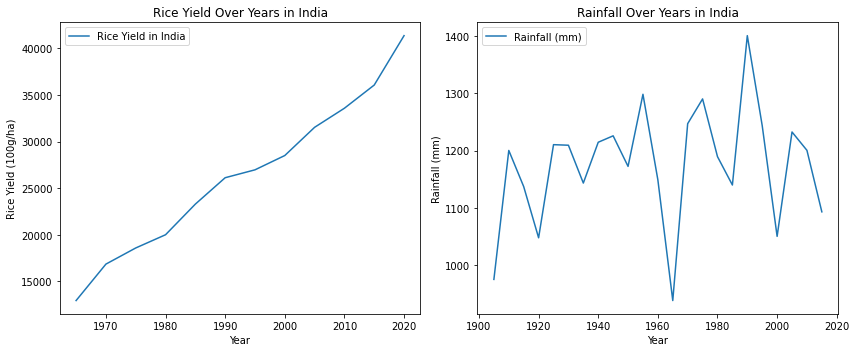

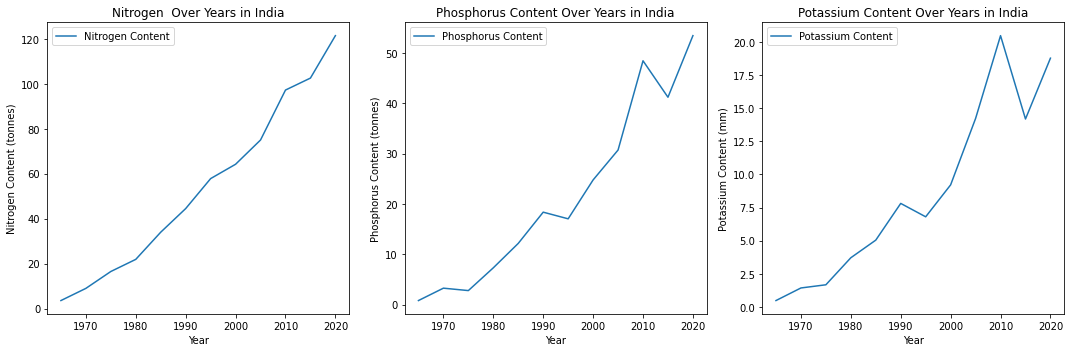

In [5]:
# Set up subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Rice Yield
df_rice = df_yield[df_yield['Year'] % 5 == 0]
axes[0].plot(df_rice['Year'], df_rice['Yield'], label='Rice Yield in India')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Rice Yield (100g/ha)')
axes[0].set_title('Rice Yield Over Years in India')
axes[0].legend()

# Plot Rainfall
filtered_rainfall = df_rainfall[df_rainfall['YEAR'] % 5 == 0]
axes[1].plot(filtered_rainfall['YEAR'], filtered_rainfall['Rainfall'], label='Rainfall (mm)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Rainfall (mm)')
axes[1].set_title('Rainfall Over Years in India')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

# Filter DataFrame for the selected years
filtered_nitrogen = df_nitrogen[df_nitrogen['Year'] % 5 == 0]
filtered_phosphate = df_phosphate[df_phosphate['Year'] % 5 == 0]
filtered_potash = df_potash[df_potash['Year'] % 5 == 0]

# Set up subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot Nitrogen Content
axes[0].plot(filtered_nitrogen['Year'], filtered_nitrogen['Nutrients_N'], label='Nitrogen Content')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Nitrogen Content (tonnes)')
axes[0].set_title('Nitrogen  Over Years in India')
axes[0].legend()

# Plot Phosphorus Content
axes[1].plot(filtered_phosphate['Year'], filtered_phosphate['Nutrients_Ph'], label='Phosphorus Content')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Phosphorus Content (tonnes)')
axes[1].set_title('Phosphorus Content Over Years in India')
axes[1].legend()

# Plot Potassium Content
axes[2].plot(filtered_potash['Year'], filtered_potash['Nutrients_P'], label='Potassium Content')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Potassium Content (mm)')
axes[2].set_title('Potassium Content Over Years in India')
axes[2].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

### Features and Target Preparation

Describe here what are the features you use and why these features. Put any Python codes to prepare and clean up your features. 

Do the same thing for the target. Describe your target and put any codes to prepare your target.

Initially, we conducted some online research to determine the useful predictors that we would like to include in our model. We evaluate the usefulness of these indicators based the extent of effect they have on the crop yield in a given year and arrived at the following factors:
- Avergage annual temperature of India
- Average rainfall in India
- Nitrogen fertiliser used per cropland area in India
- Phosphate fertiliser used per cropland area in India
- Potash fertiliser used per cropland area in India

Since the goal is to predict crop yield in India, namely rice, the target is the annual rice yield in India.

### Data used from 1961 to 2015

In [6]:
# Reset indices
df_rainfall.reset_index(inplace=True)
df_nitrogen.reset_index(inplace=True)
df_temp.reset_index(inplace=True)
df_yield.reset_index(inplace=True)
df_potash.reset_index(inplace=True)
df_phosphate.reset_index(inplace=True)

#Selection of data from 1961 to 2015
new_temp=df_temp['Temp'][(df_temp['YEAR'] >= 1961) & (df_temp['YEAR'] <= 2021)].reset_index(drop=True)
new_r=df_rainfall['Rainfall'][(df_rainfall['YEAR'] >= 1961) & (df_rainfall['YEAR'] <= 2021)].reset_index(drop=True)
df_combined = pd.concat([new_r, new_temp, df_yield['Yield'],df_potash['Nutrients_P'],df_phosphate['Nutrients_Ph'],df_nitrogen['Nutrients_N'],df_yield['Year']], axis=1)
df_combined['Yield'] = df_combined['Yield'] / 1000

empty_rows = df_combined[df_combined.isnull().any(axis=1)]

# Print the rows with empty values
print("No of empty rows : ",empty_rows.shape)

#drop empty rows
df_combined = df_combined.dropna()

# Display the resulting DataFrame
print(df_combined)

    

No of empty rows :  (6, 7)
    Rainfall   Temp   Yield  Nutrients_P  Nutrients_Ph  Nutrients_N  Year
0     1403.0  28.72  15.419         0.17          0.38         1.55  1961
1     1196.4  28.89  13.959         0.22          0.51         2.05  1962
2     1210.2  29.04  15.498         0.31          0.72         2.33  1963
3     1235.1  29.09  16.171         0.43          0.92         3.42  1964
4      938.4  29.16  12.936         0.48          0.82         3.54  1965
5     1064.0  29.41  12.952         0.70          1.53         4.53  1966
6     1148.3  29.14  15.484         1.04          2.04         6.32  1967
7     1054.2  29.07  16.134         1.03          2.32         7.34  1968
8     1147.7  29.61  16.094         1.28          2.53         8.24  1969
9     1247.0  29.47  16.849         1.43          3.28         8.96  1970
10    1218.0  29.15  17.110         1.83          3.39        10.93  1971
11     948.5  29.31  16.046         2.11          3.52        11.15  1972
12    1214.

In [7]:
from scipy.stats import zscore

# Calculate z-scores only for numeric columns
numeric_columns = df_combined.select_dtypes(include=[np.number]).columns
z_scores = zscore(df_combined[numeric_columns])

# Identify outliers based on z-scores
outliers = (np.abs(z_scores) > 1.5).all(axis=1)
print("Number of outliers:", outliers.sum())

Number of outliers: 0


### Correlation matrix 

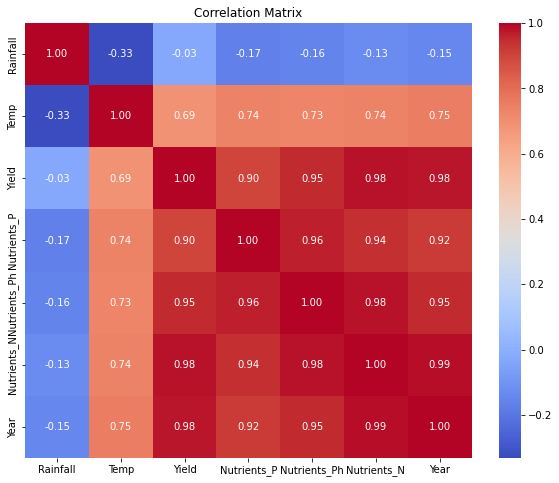

In [8]:
# Plot a correlation matrix heatmap
correlation_matrix = df_combined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Building Model
Multiple Linear Regression Model that predicts Rice Yield in India 

The objective of the project is to develop a predictive model for estimating rice yield in India based on relevant environmental factors. The model utilizes a linear regression approach, incorporating features such as rainfall, temperature, and nutrient content, specifically phosphorus. 

The dataset is divided into training and test sets, and the features are normalized using z normalization. The core of the model lies in the implementation of gradient descent to optimize the regression coefficients. By iteratively adjusting these coefficients, the model aims to minimize the mean squared error, ultimately enhancing its predictive accuracy. 

The main challenge is finding the right balance between making accurate predictions and avoiding overfitting, especially in the complex context of predicting agricultural yield. The aim is to help decision-making in agriculture by giving reliable estimates of rice yield in India using important environmental factors.
 

In [9]:
# get features and targets from data frame
df_feature, df_target = get_features_targets(df_combined,["Rainfall","Temp","Nutrients_N","Nutrients_P","Nutrients_Ph"],["Yield"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature,df_target,random_state=42,test_size=0.2)


# normalize the feature using z normalization
df_feature_train_z,means,stds = normalize_z(df_feature_train)


X = prepare_feature(df_feature_train_z)
target = prepare_target(df_target_train)

iterations = 30000
alpha = 0.01
beta = np.zeros((6,1))

# call the gradient_descent function
beta, J_storage = gradient_descent_linreg(X,target,beta,alpha,iterations)

# call the predict method to get the predicted values
pred = predict_linreg(df_feature_test,beta)

[[ 2.40959545e+01]
 [ 7.23184627e-01]
 [ 3.00097804e-03]
 [ 7.69547899e+00]
 [-7.27850950e-01]
 [ 2.28170777e-01]]


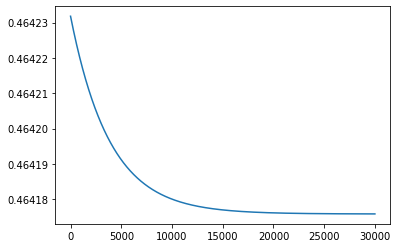

In [10]:
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
print(beta)


plt.plot(J_storage)

In [11]:
pred = predict_linreg(df_feature_test,beta)
print(pred)

[[14.58998829]
 [17.09252   ]
 [15.68889336]
 [19.26875279]
 [20.99014862]
 [25.08625531]
 [26.11058936]
 [25.91268504]
 [28.48087377]
 [35.29054237]
 [36.54425109]]


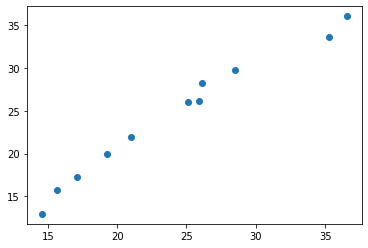

In [12]:
# Scatter plot to visualize the relationship between predicted and actual values
plt.scatter(pred,df_target_test)

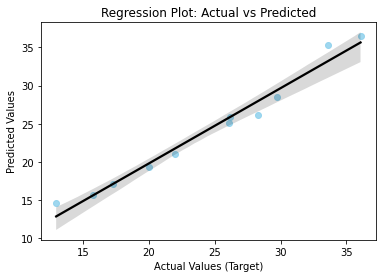

In [13]:
# This plot helps visually assess how well the model predictions align with the actual values.
# It allows us to observe if there's a linear relationship between the actual and predicted values.
# the points follow the black line, representing a perfect alignment between actual and predicted.
target = np.array(df_target_test)
sns.regplot(x=target, y=pred, scatter_kws={"color": "skyblue"}, line_kws={"color": "black"})
plt.xlabel('Actual Values (Target)')
plt.ylabel('Predicted Values')
plt.title('Regression Plot: Actual vs Predicted')
plt.show()

In [14]:
r2 = r2_score(df_target_test, pred)
print(r2)

              0
Yield  0.973059


/tmp/ipykernel_112/3546096751.py:52: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  ss_res=np.matmul(err.T,err)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/tmp/ipykernel_112/3546096751.py:55: FutureWarning: Calling a ufunc on non-aligned DataFrames (

In [15]:
#Find adjusted r2
num_data_pts, num_xvariables = df_feature.shape
adjusted_r2 = 1 - (1-r2) * (num_data_pts-1)/(num_data_pts-num_xvariables-1)
print(adjusted_r2)

             0
Yield  0.97031


In [16]:
mse = mean_squared_error(df_target_test, pred)
print(mse)

[[1.35335226]]


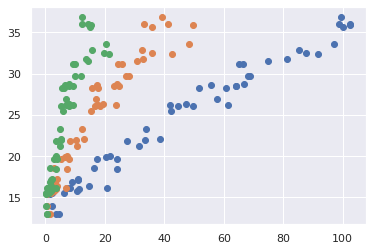

In [17]:
#there exist a positive corelation with nutrients and crop yield 
sns.set()
plt.scatter(df_combined["Nutrients_N"], df_target)

sns.set()
plt.scatter(df_combined["Nutrients_Ph"], df_target)

sns.set()
plt.scatter(df_combined["Nutrients_P"], df_target) 

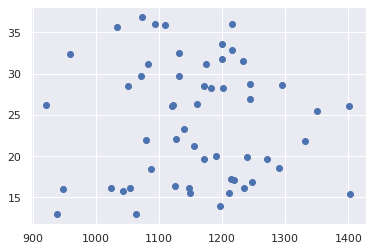

In [18]:
sns.set()
plt.scatter(df_combined["Rainfall"], df_target)

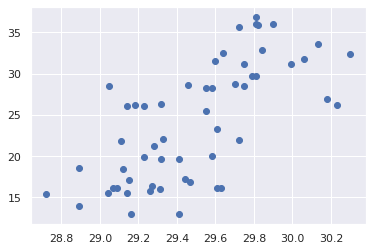

In [19]:
sns.set()
plt.scatter(df_combined["Temp"], df_target)

In [20]:
#to find corellation 
correlation = df_combined.corr(method = 'pearson')
print(correlation)

              Rainfall      Temp     Yield  Nutrients_P  Nutrients_Ph  \
Rainfall      1.000000 -0.331464 -0.026234    -0.166332     -0.158936   
Temp         -0.331464  1.000000  0.691502     0.735988      0.734486   
Yield        -0.026234  0.691502  1.000000     0.901129      0.951809   
Nutrients_P  -0.166332  0.735988  0.901129     1.000000      0.964575   
Nutrients_Ph -0.158936  0.734486  0.951809     0.964575      1.000000   
Nutrients_N  -0.130399  0.735878  0.983680     0.937752      0.979368   
Year         -0.147955  0.754106  0.977877     0.920359      0.952576   

              Nutrients_N      Year  
Rainfall        -0.130399 -0.147955  
Temp             0.735878  0.754106  
Yield            0.983680  0.977877  
Nutrients_P      0.937752  0.920359  
Nutrients_Ph     0.979368  0.952576  
Nutrients_N      1.000000  0.985668  
Year             0.985668  1.000000  


### Evaluating the Model

For our initial model, the datasets we used for training and testing includes:
- Total amount of fertiliser used per cropland area in India from 1961-2021
- Annual rainfall in India from 1901-2015
- Annual temperature in India from 1901-2015

Using these datasets, the r2 value and mean square error(mse) was 0.927894 and 3.62223866 respectively. Considering the range of values for rice yield in India is from 15.419 to 42.137, within the year 1961-2015, mse is considerably high which indicates lack of effective learning for the model. This can result in inaccurate predictions as the average difference between the actual and predicted value of rice yield is fairly high and thus, we decided to try a different dataset for training and testing, to improve the model.

For our current model, the datasets we used for training and testing includes:
- Amount of nitrogen fertilisers used per cropland area in India from 1961-2015
- Amount of phosphate fertilisers used per cropland area in India from 1961-2015
- Amount of potash fertilisers used per cropland area in India from 1961-2015
- Annual rainfall in India from 1901-2015
- Annual temperature in India from 1901-2015

Using these datasets, the r2 value and mean square error(mse) was 0.973059 and 1.35335226 respectively. Compared to the previous model, the current r2 value is considerably higher and the mse is lower, indicating that achieved regression has a better fit to the actual values compared to the previous model. This model also takes into account the specific impacts that each fertiliser have on the rice yield which makes it more transparent and improves its ability to generalise new data. Overall, the current model will be able to more accurately predict rice yield, making a more ideal model to use.

In [21]:
new_nutrients_col=df_nitrogen["Nutrients_N"]+df_potash["Nutrients_P"]+df_phosphate["Nutrients_Ph"]

df_combined_new_nutrients=df_combined.copy()
df_combined_new_nutrients=df_combined_new_nutrients.drop(['Nutrients_N','Nutrients_Ph','Nutrients_P'],axis=1)
df_combined_new_nutrients["Total_Nutrients"]=new_nutrients_col

print(df_combined_new_nutrients)


    Rainfall   Temp   Yield  Year  Total_Nutrients
0     1403.0  28.72  15.419  1961             2.10
1     1196.4  28.89  13.959  1962             2.78
2     1210.2  29.04  15.498  1963             3.36
3     1235.1  29.09  16.171  1964             4.77
4      938.4  29.16  12.936  1965             4.84
5     1064.0  29.41  12.952  1966             6.76
6     1148.3  29.14  15.484  1967             9.40
7     1054.2  29.07  16.134  1968            10.69
8     1147.7  29.61  16.094  1969            12.05
9     1247.0  29.47  16.849  1970            13.67
10    1218.0  29.15  17.110  1971            16.15
11     948.5  29.31  16.046  1972            16.78
12    1214.0  29.44  17.259  1973            17.10
13    1043.7  29.26  15.744  1974            15.45
14    1290.2  28.89  18.582  1975            20.94
15    1124.8  29.27  16.372  1976            20.46
16    1270.4  29.41  19.613  1977            25.72
17    1239.3  29.23  19.912  1978            30.51
18    1023.4  29.63  16.105  19

In [22]:
#Build the model 

# get features and targets from data frame
df_feature_new, df_target_new = get_features_targets(df_combined_new_nutrients,["Rainfall","Temp","Total_Nutrients"],["Yield"])

# split the data into training and test data sets
df_feature_train_new, df_feature_test_new, df_target_train_new, df_target_test_new = split_data(df_feature_new,df_target_new,random_state=42,test_size=0.2)


# normalize the feature using z normalization
df_feature_train_z_new,means,stds = normalize_z(df_feature_train_new)


X_new = prepare_feature(df_feature_train_z_new)
target_new = prepare_target(df_target_train_new)

iterations_new = 30000
alpha_new = 0.01
beta_new = np.zeros((4,1))

# call the gradient_descent function
beta_new, J_storage_new = gradient_descent_linreg(X_new,target_new,beta_new,alpha_new,iterations_new)

# call the predict method to get the predicted values
pred_new = predict_linreg(df_feature_test_new,beta_new)

r2_new = r2_score(df_target_test_new, pred_new)
print("R2 value before seperating n p k content columns : ",r2_new)
print("R2 value after seperating n p k content columns : ",r2)

mse_new = mean_squared_error(df_target_test_new, pred_new)
print("MSE value before seperating n p k content columns : ",mse_new)
print("MSE value after seperating n p k content columns : ",mse)





R2 value before seperating n p k content columns :                0
Yield  0.927894
R2 value after seperating n p k content columns :                0
Yield  0.973059
MSE value before seperating n p k content columns :  [[3.62223866]]
MSE value after seperating n p k content columns :  [[1.35335226]]


/tmp/ipykernel_112/3546096751.py:52: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  ss_res=np.matmul(err.T,err)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/tmp/ipykernel_112/3546096751.py:55: FutureWarning: Calling a ufunc on non-aligned DataFrames (

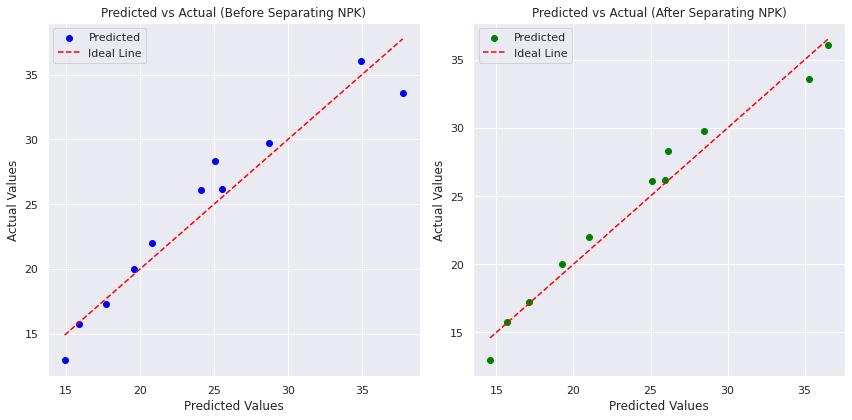

In [23]:
plt.figure(figsize=(12, 6))

# Scatter plot for predicted values before separating N, P, K
plt.subplot(1, 2, 1)
plt.scatter(pred_new, df_target_test_new, color='blue', label='Predicted')
plt.plot([min(pred_new), max(pred_new)], [min(pred_new), max(pred_new)], linestyle='--', color='red', label='Ideal Line')
plt.title('Predicted vs Actual (Before Separating NPK)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()

# Scatter plot for predicted values after separating N, P, K
plt.subplot(1, 2, 2)
plt.scatter(pred, df_target_test, color='green', label='Predicted')
plt.plot([min(pred), max(pred)], [min(pred), max(pred)], linestyle='--', color='red', label='Ideal Line')
plt.title('Predicted vs Actual (After Separating NPK)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()

plt.tight_layout()
plt.show()

### Improving the Model

1) Changing the model from Linear Regression to Polynomial Regression
  - Polynomial regression mitigated underfitting by introducing higher-order terms, allowing the model to capture more intricate details in the data.
  - Our R2 value increased and MSE decreased , showing Accuracy.
  - In agriculture , multiple factors interact to produce crop yield ,therefore , Polynomial terms allow for capturing interactions between features, offering a more better understanding of how various factors work together to influence crop yield
  
2) More Datapoints
  - Increases stability and reliability of model due to more accurate reflection of the model's true capabilities
  - more robust in the face of variations and uncertainties present in real-world applications
  - better feature learning for model, that leads to better results

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

degree = 3 
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
features = df_combined[["Rainfall", "Temp", "Nutrients_N", "Nutrients_P", "Nutrients_Ph"]]
target = df_combined["Yield"]

# Fit the polynomial model
poly_model.fit(features,target)

# Evaluate the model
poly_predictions = poly_model.predict(df_feature_test)
mae_poly = mean_absolute_error(y_true=df_target_test, y_pred=poly_predictions)
mse_poly = mean_squared_error(y_true=df_target_test, y_pred=poly_predictions)
r2_poly = r2_score(y_true=df_target_test, y_pred=poly_predictions)

print("Polynomial Model - Mean Absolute Error:", mae_poly)
print("Polynomial Model - Mean Squared Error:", mse_poly)
print("Polynomial Model - R-squared:", r2_poly)




Polynomial Model - Mean Absolute Error: 0.002798134601177373
Polynomial Model - Mean Squared Error: 1.6281022899784566e-05
Polynomial Model - R-squared: 0.999999675901403


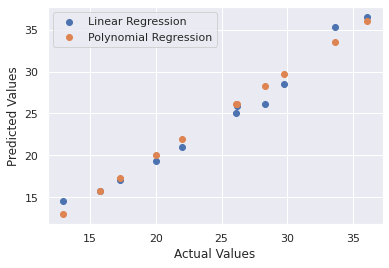

In [25]:
# Scatter plot to visually compare model predictions with actual values.
# Ideally, points should align along the 45-degree diagonal line.
# Closeness to the line and the spread of points provide insights into model accuracy.
# Compare linear and polynomial regression plots to assess model performance.

# Scatter plot for Linear Regression
plt.scatter(df_target_test, pred, label='Linear Regression')

# Scatter plot for Polynomial Regression
plt.scatter(df_target_test, poly_predictions, label='Polynomial Regression')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


### Discussion and Analysis
In our pursuit of addressing food security and safety concerns, we created a multiple regression model for farmers to predict crop yield based on factors such as Precipitation, Rainfall and Nutrients in the Country. We created a simple model for rice yield in India, and have further plans to create further sub models for countries and different crops.

Our major aim is to help farmers identify and predict crop yeild based on features, so that farmers can strategically determine the optimal amount of nutrients required for their soil, plan their crop timelines effectively, and make informed decisions based on anticipated climate conditions that will lead to better food security.

Analyzing our model helped us better understand our model and its accuracy.

#### R2 Analysis

In [26]:
print(r2)

              0
Yield  0.973059


 ###### R2 value between 0.2 to 1 indicates a Good Fit and ability to predict data accurately

#### MSE Analysis

In [27]:
print(mse)

[[1.35335226]]


###### MSE value of 1.35 indicates that the average difference between the predicted and actual crop yield is 1.35 100kg/hectare.

#### Residual Analysis

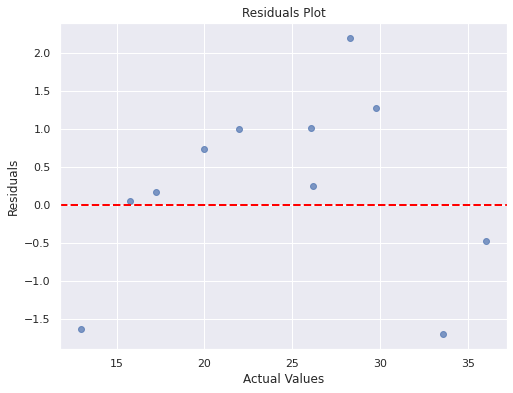

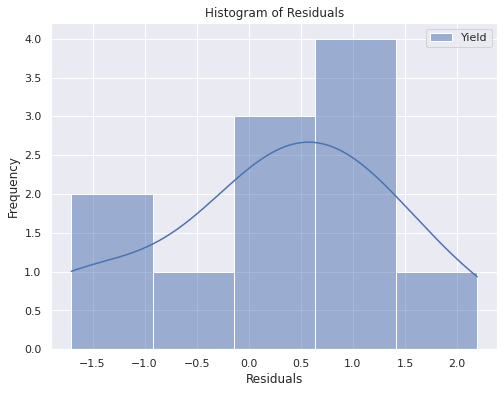

In [28]:

residuals = df_target_test - pred

# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(df_target_test, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


###### As the points for the scatter plot are scattered around the zero line, it indicates that our model makes unbiased predictions with good variability


###### the normal distribution of the histogram and the bell curve, indicates that the model provides a good fit to the data

#### The beta coefficients

##### each feature's beta value represents the change in the predicted output (crop yield) for a one-unit change in that particular feature, holding other features constant

In [29]:
print(beta)

[[ 2.40959545e+01]
 [ 7.23184627e-01]
 [ 3.00097804e-03]
 [ 7.69547899e+00]
 [-7.27850950e-01]
 [ 2.28170777e-01]]


In [30]:
print(beta[0]) #the itercept B_0 value

[24.09595455]


##### With a beta value of 0.72, an increase in rainfall by one mm is associated with an increase in crop yield (100kg/Hectare), keeping the other values constant.

In [31]:
print(beta[1]) # B_1 - Coefficient of B_1

[24.09595455]


In [ ]:
print(beta[2])  # B_2 - Coefficient of B_1

In [32]:
print(beta[3])  # B_3- Coefficient of B_1

[7.69547899]


In [33]:
print(beta[4]) # B_4- Coefficient of B_1

[-0.72785095]


In [35]:
print(beta[5]) # B_5- Coefficient of B_1

[0.22817078]


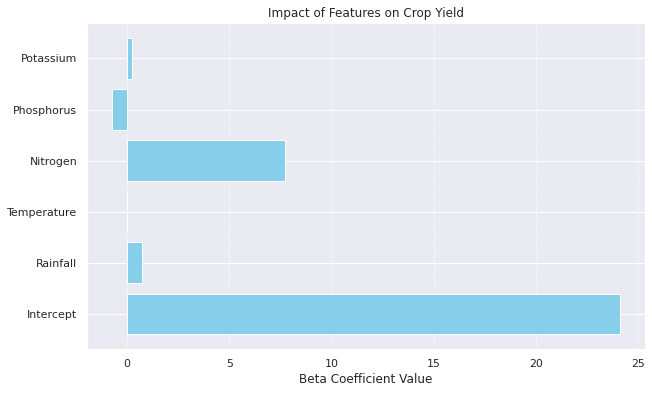

In [36]:
import matplotlib.pyplot as plt
import numpy as np


feature_names = ["Intercept", "Rainfall", "Temperature", "Nitrogen", "Phosphorus", "Potassium"]


beta_values = [24.10, 0.72, 0.003, 7.70, -0.73, 0.23]

# Plot the beta values
plt.figure(figsize=(10, 6))
plt.barh(feature_names, beta_values, color='skyblue')
plt.xlabel('Beta Coefficient Value')
plt.title('Impact of Features on Crop Yield')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

##### Features with larger magnitude beta values have a stronger impact on the predicted crop yield , indicating features such as Nitrogen has a good impact on crop yeild whereas feature like Phosphorus Content in the soil has a negative impact on crop yield.

Through Research we found that only phosphorus content in the soil can have a negative impact on important soil organisms such as fungi that will prevent healthy plant growth, that justifies its negative impact on crop yield.

We also found that nitrogen content in the soil has a greater positive impact on rice compared to other nutrients due to its importance in photosynthesis for plants that justifies its importance for crop yields

#### Limitations

1) The model doesn't consider region-specific farming methods
2) Model limitations in areas heavily reliant on advanced technology
3) Model lacks adaptability to real-time market changes

#### Conclusions

Our goal is not just to benefit individual farmers but to positively impact the global community, through increasing production of rice, a major crop exported from india to all over the world.In the future, we aim to broaden our model's scope, covering multiple countries and diverse crops. 

In conclusion, our regression model serves as a valuable tool for predicting rice yield in India based on key features like soil nutrients, temperature, and precipitation. Through extensive analysis and evaluation, we have established a robust model that shows a high degree of accuracy, as evidenced by the R-squared value and other relevant metrics. 
By understanding the relationships between environmental factors and rice production, farmers can make informed decisions, optimizing nutrient application and adapting cultivation practices to climatic conditions. 

As we strive for a more comprehensive understanding of the factors influencing rice cultivation, our work lays the foundation for future advancements in agricultural modeling, ultimately supporting food security and fostering sustainable farming practices.